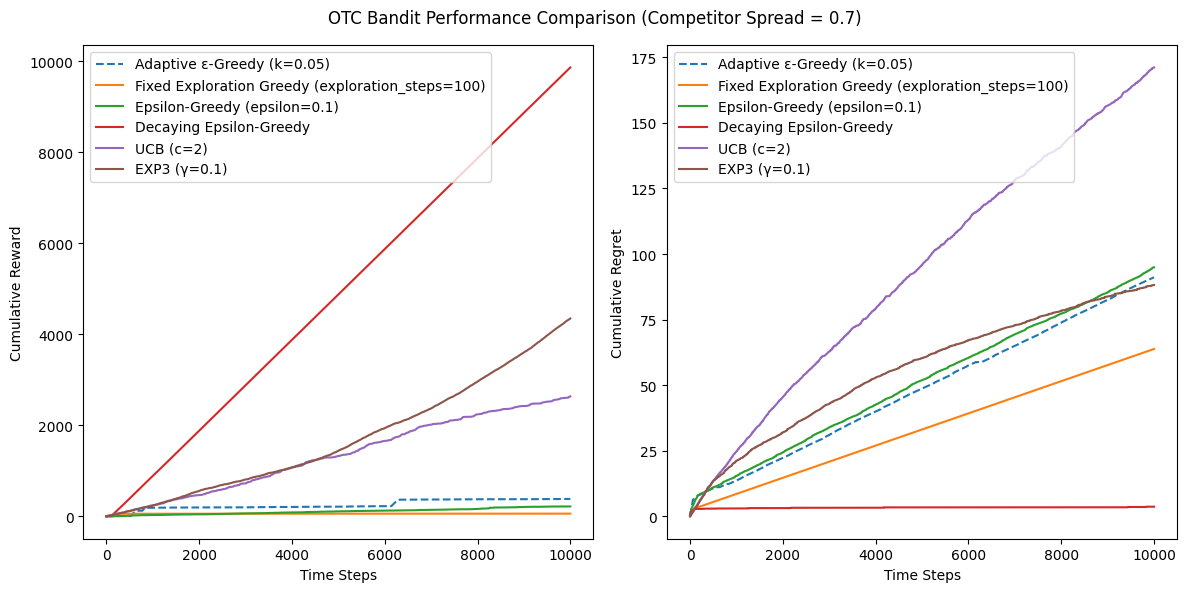

In [1]:
import numpy as np
import matplotlib.pyplot as plt

"""
Multi-Armed Bandit Algorithms in OTC (Order-to-Cover) Market Environment
This code compares various bandit algorithms in a simulated financial market scenario
where agents compete through spread selection.
"""

# ==========================
# Setting Evironment
# ==========================
class OTCEnvironment:
    """
    Simulates an Order-to-Cover market environment with spread-based execution probabilities
    
    Parameters:
    - spreads: List of available spreads (arms)
    - competitor_spread: Fixed spread used by market competitor
    - alpha: Market competitiveness parameter (higher = more competitive)
    """
    def __init__(self, spreads, A=140, k=1.5, dt=0.005):
        self.spreads = np.array(spreads)
        self.A = A
        self.k = k
        self.dt = dt
        
    def get_execution_prob(self, delta):
        """Calculate execution probability as λ(δ) * dt"""
        lambda_delta = self.A * np.exp(-self.k * delta)
        prob = lambda_delta * self.dt
        return min(prob, 1.0)  # Ensure probability ≤ 1
        
    def pull_arm(self, arm):
        """Returns δ if executed, 0 otherwise"""
        delta = self.spreads[arm]
        prob = self.get_execution_prob(delta)
        win = np.random.binomial(1, prob)
        return win * delta

# ==========================
# New Adaptive Epsilon-Greedy
# ==========================
class AdaptiveEpsilonGreedy:
    """
    Epsilon-Greedy variant with UCB-inspired adaptive exploration rate
    Exploration probability ε_t = min(1, k*sqrt(log(t)/n_min))
    where n_min is minimum pull count across arms
    
    Parameters:
    - num_arms: Number of arms/spreads
    - k: Exploration scaling factor
    """
    def __init__(self, num_arms, k):
        self.num_arms = num_arms
        self.k = k
        self.counts = np.zeros(num_arms)  # Pull counts per arm
        self.values = np.zeros(num_arms)  # Empirical reward averages
        self.t = 1  # Time step counter
        
    def select_arm(self):
        """Select arm using ε-greedy strategy with adaptive exploration rate"""
        if np.random.random() < self._calculate_epsilon():
            return np.random.randint(self.num_arms)  # Uniform exploration
        else:
            return np.argmax(self.values)  # Greedy exploitation
            
    def _calculate_epsilon(self):
        """Calculate adaptive exploration rate using UCB-style uncertainty"""
        n_min = np.min(self.counts) if np.all(self.counts > 0) else 1
        return min(1, self.k * np.sqrt(np.log(self.t) / n_min))
        
    def update(self, arm, reward):
        """Update arm estimates using incremental average"""
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1  # Increment time step

# ==========================
# Fixed Exploration Then Exploitation Greedy
# ==========================
class FixedExplorationThenGreedy:
    def __init__(self, num_arms, exploration_steps):
        self.num_arms = num_arms
        self.exploration_steps = exploration_steps
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        if self.t <= self.exploration_steps:
            return (self.t - 1) % self.num_arms
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# Epsilon-Greedy
# ==========================
class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)

    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

# ==========================
# Epsilon-Greedy with Decaying Exploration
# ==========================
class EpsilonGreedyDecaying:
    def __init__(self, num_arms, epsilon_schedule):
        self.num_arms = num_arms
        self.epsilon_schedule = epsilon_schedule
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1

    def select_arm(self):
        epsilon = self.epsilon_schedule(self.t)
        if np.random.rand() < epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# UCB
# ==========================
class UCB:
    def __init__(self, num_arms, c):
        self.num_arms = num_arms
        self.c = c
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 1
        
    def select_arm(self):
        for arm in range(self.num_arms):
            if self.counts[arm] == 0:
                return arm
        ucb_values = self.values + self.c * np.sqrt(np.log(self.t) / self.counts)
        return np.argmax(ucb_values)
        
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]
        self.t += 1

# ==========================
# EXP3
# ==========================
class EXP3:
    def __init__(self, num_arms, gamma):
        self.num_arms = num_arms
        self.gamma = gamma
        self.weights = np.ones(num_arms)
        self.t = 1
        
    def select_arm(self):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        return np.random.choice(self.num_arms, p=probabilities)
        
    def update(self, arm, reward):
        probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + \
                       self.gamma / self.num_arms
        estimated_reward = reward / probabilities[arm]
        self.weights[arm] *= np.exp(self.gamma * estimated_reward / self.num_arms)
        self.t += 1

# ==========================
# Experiment Runner
# ==========================
def run_experiment(bandit_class, bandit_params, env, num_steps):
    """
    Run bandit algorithm experiment and track performance metrics
    
    Parameters:
    - bandit_class: Algorithm class to test
    - bandit_params: Dictionary of algorithm parameters
    - env: OTCEvironment instance
    - num_steps: Number of iterations
    
    Returns:
    - cum_rewards: Cumulative correct arm selections
    - cum_regret: Cumulative regret compared to optimal
    """
    bandit = bandit_class(**bandit_params)
    rewards = []
    regrets = []
    
    # Precompute optimal arm once
    expected_rewards = [s * env.get_execution_prob(s) for s in env.spreads]
    optimal_arm = np.argmax(expected_rewards)
    optimal_reward = expected_rewards[optimal_arm]
    
    for t in range(num_steps):
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        bandit.update(arm, reward)
        
        # Calculate instantaneous regret
        current_expected = env.spreads[arm] * env.get_execution_prob(env.spreads[arm])
        regret = optimal_reward - current_expected
        regrets.append(regret)
        rewards.append(1 if arm == optimal_arm else 0)
    
    return np.cumsum(rewards), np.cumsum(regrets)

# ==========================
# Experiment Configuration
# ==========================

spreads = [0.1, 0.3, 0.5, 0.7, 0.9] # Available spreads
num_arms = len(spreads) # Number of arms
competitor_spread = 0.7 # Competitor's fixed spread
alpha = 0.4 # High alpha means high competitiveness (steep execution prob curve)
A = 140       # From literature's numerical setup
k = 1.5       # From literature's numerical setup
dt = 0.005    # From literature's time step
env = OTCEnvironment(spreads, A=A, k=k, dt=dt)
num_steps = 10000  # Simulation length 

# ==========================
# Algorithm Parameters
# ==========================

k = 0.05  # Adaptive ε-Greedy exploration scaling
exploration_steps = 100  # Fixed exploration phase length
epsilon = 0.1  # Standard ε-Greedy exploration rate
c = 2  # UCB exploration weight
gamma = 0.1  # EXP3 exploration parameter
def epsilon_schedule(t): # ε decay schedule for Decaying ε-Greedy
    #return 1 / (t + 1)
    #return 1 / np.sqrt(t + 1)
    return np.log(t+1)/(t+1)

# ==========================
# Running Experiments
# ==========================

'''
# Test multiple k values for AdaptiveEpsilonGreedy

k_values = np.linspace(0.05, 1, 5)  # [0.1, 0.325, 0.55, 0.775, 1.0]
aeg_results = []

for k in k_values:
    reward, regret = run_experiment(AdaptiveEpsilonGreedy, 
                                  {'num_arms': len(spreads), 'k': k}, 
                                  env, num_steps)
    aeg_results.append((k, reward, regret))
'''
# Adaptive ε-Greedy
adaptive_epsilon_greedy_reward, adaptive_epsilon_greedy_regret = run_experiment(AdaptiveEpsilonGreedy, {'num_arms': num_arms, 'k': k}, env, num_steps)
# Fixed exploration Greedy
fixed_exploration_greedy_reward, fixed_exploration_greedy_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': exploration_steps}, env, num_steps)
# ε-Greedy
epsilon_greedy_reward, epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': epsilon}, env, num_steps)
#Decaying ε-Greedy
decaying_epsilon_greedy_reward, decaying_epsilon_greedy_regret = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env, num_steps)
# UCB
ucb_reward, ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': c}, env, num_steps)
# EXP3
exp3_reward, exp3_regret = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': gamma}, env, num_steps)

# ==========================
# Visualization
# ==========================

plt.figure(figsize=(12, 6))

# Reward Plot
plt.subplot(1, 2, 1)
'''
# Plot AEG variants

for k, reward, _ in aeg_results:
    plt.plot(reward, label=f'Adaptive ε-Greedy (k={k:.2f})', alpha=0.7, linestyle='--')
'''
plt.plot(adaptive_epsilon_greedy_reward, label=f'Adaptive ε-Greedy (k={k})', linestyle='--')
plt.plot(fixed_exploration_greedy_reward, label=f'Fixed Exploration Greedy (exploration_steps={exploration_steps})')
plt.plot(epsilon_greedy_reward, label=f'Epsilon-Greedy (epsilon={epsilon})')
plt.plot(decaying_epsilon_greedy_reward, label='Decaying Epsilon-Greedy')
plt.plot(ucb_reward, label=f'UCB (c={c})')
plt.plot(exp3_reward, label=f'EXP3 (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()


# Regret Plot
plt.subplot(1, 2, 2)
'''
# Plot AEG variants

for k, _, regret in aeg_results:
    plt.plot(regret, label=f'Adaptive ε-Greedy (k={k:.2f})', alpha=0.7, linestyle='--')
'''
plt.plot(adaptive_epsilon_greedy_regret, label=f'Adaptive ε-Greedy (k={k})', linestyle='--')
plt.plot(fixed_exploration_greedy_regret, label=f'Fixed Exploration Greedy (exploration_steps={exploration_steps})')
plt.plot(epsilon_greedy_regret, label=f'Epsilon-Greedy (epsilon={epsilon})')
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')
plt.plot(ucb_regret, label=f'UCB (c={c})')
plt.plot(exp3_regret, label=f'EXP3 (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.suptitle(f"OTC Bandit Performance Comparison (Competitor Spread = {competitor_spread})")
plt.tight_layout()
plt.show()

## Single-agent Non-stationary environment

[Step 1000] Competitor spread changed: 0.7 ➜ 0.9
[Step 2000] Competitor spread changed: 0.9 ➜ 0.5
[Step 3000] Competitor spread changed: 0.5 ➜ 0.7
[Step 4000] Competitor spread changed: 0.7 ➜ 0.5
[Step 5000] Competitor spread changed: 0.5 ➜ 0.7
[Step 6000] Competitor spread changed: 0.7 ➜ 0.7
[Step 7000] Competitor spread changed: 0.7 ➜ 0.3
[Step 8000] Competitor spread changed: 0.3 ➜ 0.9
[Step 9000] Competitor spread changed: 0.9 ➜ 0.9
[Step 10000] Competitor spread changed: 0.9 ➜ 0.3
[Step 11000] Competitor spread changed: 0.3 ➜ 0.9
[Step 12000] Competitor spread changed: 0.9 ➜ 0.7
[Step 13000] Competitor spread changed: 0.7 ➜ 0.7
[Step 14000] Competitor spread changed: 0.7 ➜ 0.9
[Step 15000] Competitor spread changed: 0.9 ➜ 0.9
[Step 16000] Competitor spread changed: 0.9 ➜ 0.3
[Step 17000] Competitor spread changed: 0.3 ➜ 0.5
[Step 18000] Competitor spread changed: 0.5 ➜ 0.9
[Step 19000] Competitor spread changed: 0.9 ➜ 0.7
[Step 20000] Competitor spread changed: 0.7 ➜ 0.1
[Step 210

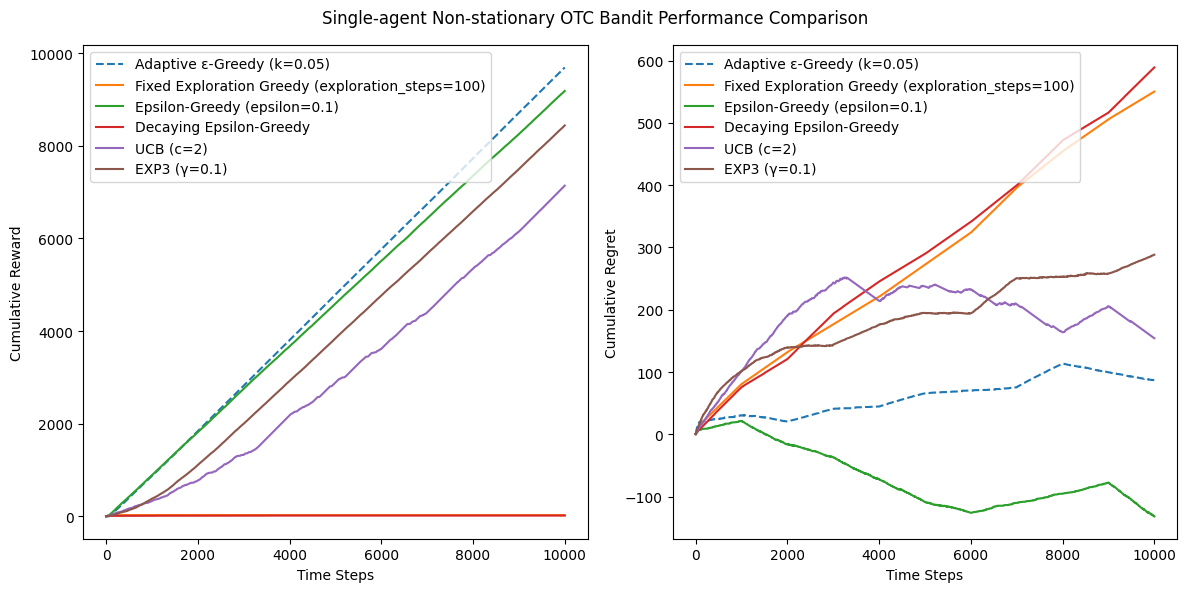

In [58]:
# ==========================
# Non-stationary OTC Environment
# ==========================
class NonStationaryOTCEnvironment(OTCEnvironment):
    """
    Extends OTCEnvironment by periodically changing the competitor's spread,
    simulating a non-stationary environment (e.g., changing market conditions).
    
    Parameters:
    - dynamic_interval: Number of steps between environment changes
    """
    def __init__(self, spreads, competitor_spread, alpha=0.3, dynamic_interval=1000):
        super().__init__(spreads, competitor_spread, alpha)
        self.dynamic_interval = dynamic_interval
        self.step_counter = 0

    def update_competitor_spread(self):
        """Periodically update competitor_spread to simulate market drift."""
        if self.step_counter % self.dynamic_interval == 0:
            old = self.competitor_spread
            self.competitor_spread = np.random.choice(self.spreads)
            print(f"[Step {self.step_counter}] Competitor spread changed: {old} ➜ {self.competitor_spread}")

    def pull_arm(self, arm):
        """Override with time-dependent spread change"""
        self.step_counter += 1
        self.update_competitor_spread()
        return super().pull_arm(arm)

# ==========================
# Non-stationary Environment Setup
# ==========================
env = NonStationaryOTCEnvironment(
    spreads, 
    competitor_spread=competitor_spread, 
    alpha=alpha,
    dynamic_interval=1000 
)

# ==========================
# Running Experiments
# ==========================

'''
# Test multiple k values for AdaptiveEpsilonGreedy

k_values = np.linspace(0.05, 1, 5)  # [0.1, 0.325, 0.55, 0.775, 1.0]
aeg_results = []

for k in k_values:
    reward, regret = run_experiment(AdaptiveEpsilonGreedy, 
                                  {'num_arms': len(spreads), 'k': k}, 
                                  env, num_steps)
    aeg_results.append((k, reward, regret))
'''
# Adaptive ε-Greedy
adaptive_epsilon_greedy_reward, adaptive_epsilon_greedy_regret = run_experiment(AdaptiveEpsilonGreedy, {'num_arms': num_arms, 'k': k}, env, num_steps)
# Fixed exploration Greedy
fixed_exploration_greedy_reward, fixed_exploration_greedy_regret = run_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': exploration_steps}, env, num_steps)
# ε-Greedy
epsilon_greedy_reward, epsilon_greedy_regret = run_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': epsilon}, env, num_steps)
#Decaying ε-Greedy
decaying_epsilon_greedy_reward, decaying_epsilon_greedy_regret = run_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env, num_steps)
# UCB
ucb_reward, ucb_regret = run_experiment(UCB, {'num_arms': num_arms, 'c': c}, env, num_steps)
# EXP3
exp3_reward, exp3_regret = run_experiment(EXP3, {'num_arms': num_arms, 'gamma': gamma}, env, num_steps)

# ==========================
# Visualization
# ==========================

plt.figure(figsize=(12, 6))

# Reward Plot
plt.subplot(1, 2, 1)
'''
# Plot AEG variants

for k, reward, _ in aeg_results:
    plt.plot(reward, label=f'Adaptive ε-Greedy (k={k:.2f})', alpha=0.7, linestyle='--')
'''
plt.plot(adaptive_epsilon_greedy_reward, label=f'Adaptive ε-Greedy (k={k})', linestyle='--')
plt.plot(fixed_exploration_greedy_reward, label=f'Fixed Exploration Greedy (exploration_steps={exploration_steps})')
plt.plot(epsilon_greedy_reward, label=f'Epsilon-Greedy (epsilon={epsilon})')
plt.plot(decaying_epsilon_greedy_reward, label='Decaying Epsilon-Greedy')
plt.plot(ucb_reward, label=f'UCB (c={c})')
plt.plot(exp3_reward, label=f'EXP3 (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()


# Regret Plot
plt.subplot(1, 2, 2)
'''
# Plot AEG variants

for k, _, regret in aeg_results:
    plt.plot(regret, label=f'Adaptive ε-Greedy (k={k:.2f})', alpha=0.7, linestyle='--')
'''
plt.plot(adaptive_epsilon_greedy_regret, label=f'Adaptive ε-Greedy (k={k})', linestyle='--')
plt.plot(fixed_exploration_greedy_regret, label=f'Fixed Exploration Greedy (exploration_steps={exploration_steps})')
plt.plot(epsilon_greedy_regret, label=f'Epsilon-Greedy (epsilon={epsilon})')
plt.plot(decaying_epsilon_greedy_regret, label='Decaying Epsilon-Greedy')
plt.plot(ucb_regret, label=f'UCB (c={c})')
plt.plot(exp3_regret, label=f'EXP3 (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret")
plt.legend()

plt.suptitle(f"Single-agent Non-stationary OTC Bandit Performance Comparison")
plt.tight_layout()
plt.show()

## Multi-agent Stationary environment

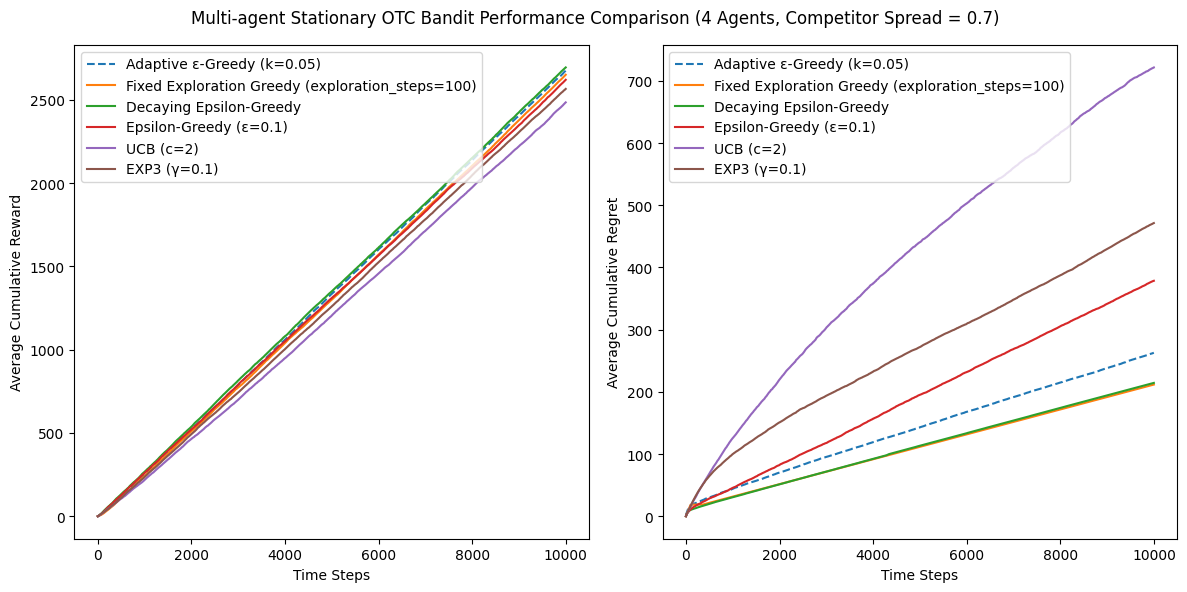

In [60]:
# ==========================
# Multi-Agent Stationary OTC Environment
# ==========================
class MultiAgentOTCEnvironment(OTCEnvironment):
    def __init__(self, spreads, competitor_spread, alpha=0.3, penalty_mode='linear', adversarial_penalty=0.1):
        super().__init__(spreads, competitor_spread, alpha)
        self.penalty_mode = penalty_mode
        self.adversarial_penalty = adversarial_penalty

    def get_penalty_multiplier(self, count):
        if self.penalty_mode == 'linear':
            return 1.0 / (1.0 + self.adversarial_penalty * count)
        elif self.penalty_mode == 'log':
            return 1.0 / (1.0 + self.adversarial_penalty * np.log(1 + count))
        elif self.penalty_mode == 'none':
            return 1.0
        else:
            raise ValueError(f"Unsupported penalty mode: {self.penalty_mode}")

    def pull_arms_multiagent(self, arm_selections):
        arm_counts = np.bincount(arm_selections, minlength=len(self.spreads))
        rewards = []
        for arm in arm_selections:
            s = self.spreads[arm]
            prob = self.get_execution_prob(s)
            win = np.random.binomial(1, prob)
            penalty = self.get_penalty_multiplier(arm_counts[arm])
            rewards.append(win * s * penalty)
        return rewards

# ==========================
# Multi-Agent Experiment Runner
# ==========================
def run_multiagent_experiment(bandit_class, bandit_params, env, num_agents, num_steps):
    agents = [bandit_class(**bandit_params) for _ in range(num_agents)]
    expected_rewards = [s * env.get_execution_prob(s) for s in env.spreads]
    optimal_arm = np.argmax(expected_rewards)
    optimal_reward = expected_rewards[optimal_arm]

    rewards = [[] for _ in range(num_agents)]
    regrets = [[] for _ in range(num_agents)]

    for t in range(num_steps):
        arm_choices = [agent.select_arm() for agent in agents]
        reward_list = env.pull_arms_multiagent(arm_choices)

        for i in range(num_agents):
            agents[i].update(arm_choices[i], reward_list[i])
            current_expected = env.spreads[arm_choices[i]] * env.get_execution_prob(env.spreads[arm_choices[i]])
            regret = optimal_reward - current_expected
            regrets[i].append(regret)
            rewards[i].append(reward_list[i])

    cum_rewards_list = [np.cumsum(r) for r in rewards]
    cum_regrets_list = [np.cumsum(r) for r in regrets]
    return cum_rewards_list, cum_regrets_list

# ==========================
# Experiment Configuration
# ==========================

spreads = [0.1, 0.3, 0.5, 0.7, 0.9] # Available spreads
num_arms = len(spreads) # Number of arms
competitor_spread = 0.7 # Competitor's fixed spread
env_multi = MultiAgentOTCEnvironment(spreads, competitor_spread, alpha, penalty_mode='linear', adversarial_penalty=0.2)
alpha = 0.4 # High alpha means high competitiveness (steep execution prob curve)
num_steps = 10000  # Simulation length 
num_agents = 4

# ==========================
# Algorithm Parameters
# ==========================

k = 0.05  # Adaptive ε-Greedy exploration scaling
exploration_steps = 100  # Fixed exploration phase length
epsilon = 0.1  # Standard ε-Greedy exploration rate
c = 2  # UCB exploration weight
gamma = 0.1  # EXP3 exploration parameter
def epsilon_schedule(t): # ε decay schedule for Decaying ε-Greedy
    #return 1 / (t + 1)
    #return 1 / np.sqrt(t + 1)
    return np.log(t+1)/(t+1)

# Run each algorithm
# Adaptive ε-Greedy
ma_adaptive_epsilon_greedy_reward, ma_adaptive_epsilon_greedy_regret = run_multiagent_experiment(AdaptiveEpsilonGreedy, {'num_arms': num_arms, 'k': k}, env_multi, num_agents, num_steps)
# Fixed exploration Greedy
ma_fixed_exploration_greedy_reward, ma_fixed_exploration_greedy_regret = run_multiagent_experiment(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': exploration_steps}, env_multi, num_agents, num_steps)
# ε-Greedy
ma_eps_reward, ma_eps_regret = run_multiagent_experiment(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': epsilon}, env_multi, num_agents, num_steps)
#Decaying ε-Greedy
ma_decaying_reward, ma_decaying_regret = run_multiagent_experiment(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env_multi, num_agents, num_steps)
# UCB
ma_ucb_reward, ma_ucb_regret = run_multiagent_experiment(UCB, {'num_arms': num_arms, 'c': c}, env_multi, num_agents, num_steps)
# EXP3
ma_exp3_reward, ma_exp3_regret = run_multiagent_experiment(EXP3, {'num_arms': num_arms, 'gamma': gamma}, env_multi, num_agents, num_steps)

# ==========================
# Visualization
# ==========================
plt.figure(figsize=(12, 6))

# Reward Plot
plt.subplot(1, 2, 1)
plt.plot(np.mean(ma_adaptive_epsilon_greedy_reward, axis=0), label=f'Adaptive ε-Greedy (k={k})', linestyle='--')
plt.plot(np.mean(ma_fixed_exploration_greedy_reward, axis=0), label=f'Fixed Exploration Greedy (exploration_steps={exploration_steps})')
plt.plot(np.mean(ma_decaying_reward, axis=0), label='Decaying Epsilon-Greedy')
plt.plot(np.mean(ma_eps_reward, axis=0), label=f'Epsilon-Greedy (ε={epsilon})')
plt.plot(np.mean(ma_ucb_reward, axis=0), label=f'UCB (c={c})')
plt.plot(np.mean(ma_exp3_reward, axis=0), label=f'EXP3 (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Average Cumulative Reward")
plt.legend()

# Regret Plot
plt.subplot(1, 2, 2)
plt.plot(np.mean(ma_adaptive_epsilon_greedy_regret, axis=0), label=f'Adaptive ε-Greedy (k={k})', linestyle='--')
plt.plot(np.mean(ma_fixed_exploration_greedy_regret, axis=0), label=f'Fixed Exploration Greedy (exploration_steps={exploration_steps})')
plt.plot(np.mean(ma_decaying_regret, axis=0), label='Decaying Epsilon-Greedy')
plt.plot(np.mean(ma_eps_regret, axis=0), label=f'Epsilon-Greedy (ε={epsilon})')
plt.plot(np.mean(ma_ucb_regret, axis=0), label=f'UCB (c={c})')
plt.plot(np.mean(ma_exp3_regret, axis=0), label=f'EXP3 (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Average Cumulative Regret")
plt.legend()

plt.suptitle(f"Multi-agent Stationary OTC Bandit Performance Comparison ({num_agents} Agents, Competitor Spread = {competitor_spread})")
plt.tight_layout()
plt.show()


## Multi-agent Non-stationary environment

[Step 1000] Competitor spread changed: 0.7 ➜ 0.3
[Step 2000] Competitor spread changed: 0.3 ➜ 0.9
[Step 3000] Competitor spread changed: 0.9 ➜ 0.3
[Step 4000] Competitor spread changed: 0.3 ➜ 0.9
[Step 5000] Competitor spread changed: 0.9 ➜ 0.5
[Step 6000] Competitor spread changed: 0.5 ➜ 0.5
[Step 7000] Competitor spread changed: 0.5 ➜ 0.5
[Step 8000] Competitor spread changed: 0.5 ➜ 0.7
[Step 9000] Competitor spread changed: 0.7 ➜ 0.1
[Step 10000] Competitor spread changed: 0.1 ➜ 0.9
[Step 11000] Competitor spread changed: 0.9 ➜ 0.3
[Step 12000] Competitor spread changed: 0.3 ➜ 0.7
[Step 13000] Competitor spread changed: 0.7 ➜ 0.1
[Step 14000] Competitor spread changed: 0.1 ➜ 0.7
[Step 15000] Competitor spread changed: 0.7 ➜ 0.3
[Step 16000] Competitor spread changed: 0.3 ➜ 0.1
[Step 17000] Competitor spread changed: 0.1 ➜ 0.7
[Step 18000] Competitor spread changed: 0.7 ➜ 0.3
[Step 19000] Competitor spread changed: 0.3 ➜ 0.1
[Step 20000] Competitor spread changed: 0.1 ➜ 0.9
[Step 210

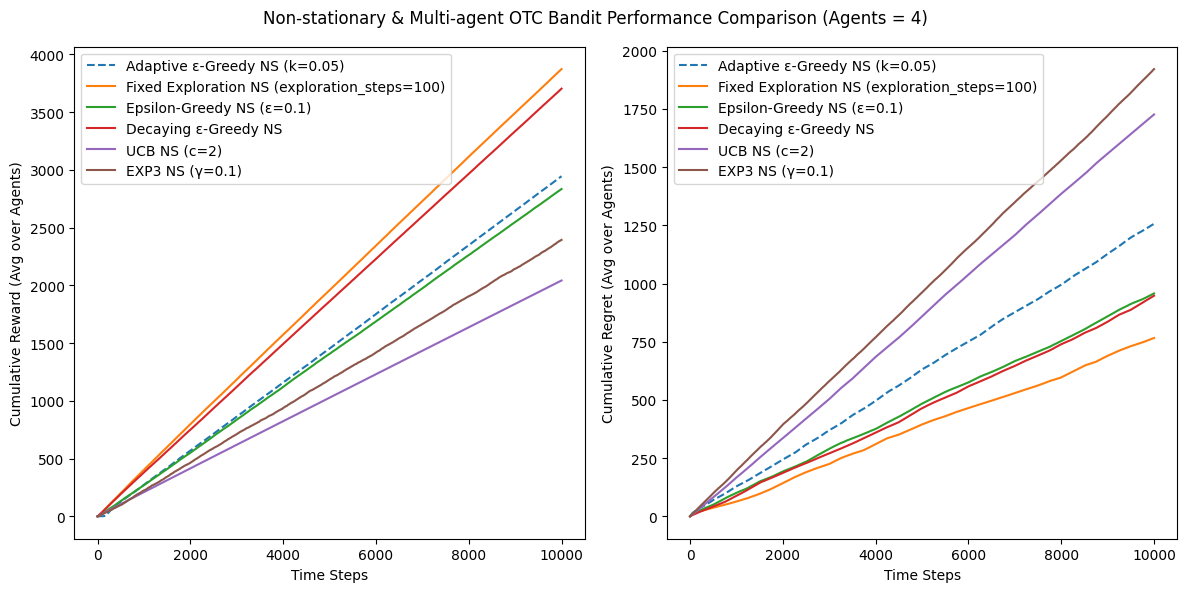

In [61]:
"""
Multi-Armed Bandit Algorithms in OTC (Order-to-Cover) Market Environment
Comparison in a Non-stationary Environment and Multi-agent Learning Scenario
"""

import numpy as np
import matplotlib.pyplot as plt

# Assume that OTCEnvironment and other bandit algorithm classes (AdaptiveEpsilonGreedy, FixedExplorationThenGreedy,
# EpsilonGreedy, EpsilonGreedyDecaying, UCB) are already defined and available in the current scope.

# ==========================
# Non-stationary Environment for Multi-agent Learning
# ==========================
class NonStationaryMultiAgentOTCEnvironment(OTCEnvironment):
    """
    Non-stationary OTC environment with two modifications:
    
    1. Dynamic update: Every 'dynamic_interval' steps, the competitor's spread is randomly re-assigned,
       simulating changes in market conditions.
    2. Adversarial penalty: When an arm is selected frequently (as measured by selection_count),
       its reward is penalized to simulate multi-agent interference.
    
    Parameters:
    - dynamic_interval: The fixed interval at which competitor_spread is updated.
    - adversarial_penalty: The penalty factor applied to frequently selected arms.
    - penalty_mode: The mode of penalty ('linear', 'log', or 'none').
    """
    def __init__(self, spreads, competitor_spread, alpha=0.3, dynamic_interval=1000, adversarial_penalty=0.1, penalty_mode='linear'):
        super().__init__(spreads, competitor_spread, alpha)
        self.dynamic_interval = dynamic_interval
        self.adversarial_penalty = adversarial_penalty
        self.penalty_mode = penalty_mode
        self.step_counter = 0

    def update_competitor(self):
        # Dynamic update: every 'dynamic_interval' steps, randomly change competitor_spread.
        if self.step_counter % self.dynamic_interval == 0:
            old = self.competitor_spread
            self.competitor_spread = np.random.choice(self.spreads)
            print(f"[Step {self.step_counter}] Competitor spread changed: {old} ➜ {self.competitor_spread}")
    
    def pull_arm(self, arm, selection_count=0):
        """
        Simulate pulling an arm with additional dynamic updates and adversarial penalty.
        
        Parameters:
        - arm: The index of the arm to pull.
        - selection_count: The cumulative number of times this arm has been selected (used for computing the penalty).
        """
        self.step_counter += 1
        self.update_competitor()
        s = self.spreads[arm]
        prob = self.get_execution_prob(s)
        # Apply adversarial penalty: the reward of a frequently chosen arm is reduced proportionally.
        if self.penalty_mode == 'linear':
            multiplier = 1.0 / (1.0 + self.adversarial_penalty * selection_count)
        elif self.penalty_mode == 'log':
            multiplier = 1.0 / (1.0 + self.adversarial_penalty * np.log(1 + selection_count))
        elif self.penalty_mode == 'none':
            multiplier = 1.0
        else:
            raise ValueError(f"Unsupported penalty mode: {self.penalty_mode}")
        
        win = np.random.binomial(1, prob)
        return win * s * multiplier

# ==========================
# Multi-agent Experiment Runner for Non-stationary Environment
# ==========================
def run_experiment_ns_multi(bandit_class, bandit_params, env_ns, num_steps, num_agents=4):
    """
    Run a multi-agent bandit algorithm experiment in a non-stationary, multi-agent learning environment.
    
    Parameters:
    - bandit_class: The bandit algorithm class to test.
    - bandit_params: Dictionary of algorithm parameters.
    - env_ns: Instance of the NonStationaryOTCEnvironment.
    - num_steps: Number of iterations (each iteration, all agents act once).
    - num_agents: Number of agents.
    
    Returns:
    - avg_cum_rewards: Cumulative reward averaged over agents.
    - avg_cum_regret: Cumulative regret averaged over agents.
    """
    # Initialize agents
    agents = [bandit_class(**bandit_params) for _ in range(num_agents)]
    # Global counts for each arm: counts the total selections across all agents (for adversarial penalty)
    global_counts = np.zeros(len(env_ns.spreads))
    
    # Arrays to record each agent's reward and regret per time step
    rewards_agents = np.zeros((num_agents, num_steps))
    regrets_agents = np.zeros((num_agents, num_steps))
    
    # Precompute the initial optimal arm based on expected rewards 
    # (Note: in a non-stationary environment, the optimal arm may change over time; here we use the initial optimal as the benchmark)
    expected_rewards = [s * env_ns.get_execution_prob(s) for s in env_ns.spreads]
    optimal_arm = np.argmax(expected_rewards)
    optimal_reward = expected_rewards[optimal_arm]
    
    for t in range(num_steps):
        for i, agent in enumerate(agents):
            arm = agent.select_arm()
            # Use global selection count as input for adversarial penalty calculation
            reward = env_ns.pull_arm(arm, selection_count=global_counts[arm])
            # Update global count: this simulates the cumulative effect of multi-agent competition
            global_counts[arm] += 1
            agent.update(arm, reward)
            
            current_expected = env_ns.spreads[arm] * env_ns.get_execution_prob(env_ns.spreads[arm])
            regret = optimal_reward - current_expected
            regrets_agents[i, t] = regret
            # For reward, we use 1 if the optimal arm was selected (for comparison), not the actual reward value
            rewards_agents[i, t] = 1 if arm == optimal_arm else 0
    
    # Compute the average cumulative reward and regret across all agents at each time step
    avg_rewards = np.mean(rewards_agents, axis=0)
    avg_regrets = np.mean(regrets_agents, axis=0)
    avg_cum_rewards = np.cumsum(avg_rewards)
    avg_cum_regret = np.cumsum(avg_regrets)
    
    return avg_cum_rewards, avg_cum_regret

# ==========================
# Experiment Configuration
# ==========================

spreads = [0.1, 0.3, 0.5, 0.7, 0.9]  # Available spreads
num_arms = len(spreads)              # Number of arms
competitor_spread = 0.7              # Initial competitor spread
alpha = 0.4                        # High alpha indicates high competitiveness
env_ns = NonStationaryMultiAgentOTCEnvironment(   # Create the non-stationary environment
    spreads, 
    competitor_spread=competitor_spread,
    alpha=alpha,
    dynamic_interval=1000,           # Update competitor spread every 1000 steps
    adversarial_penalty=0.1          # Penalty factor for frequently selected arms
)
num_steps = 10000  # Number of simulation steps
num_agents = 4     # Number of agents in the multi-agent scenario

# ==========================
# Algorithm Parameters
# ==========================
k = 0.05           # Exploration scaling parameter for Adaptive ε-Greedy
exploration_steps = 100  # Number of steps for fixed exploration phase in Fixed Exploration Then Greedy
epsilon = 0.1      # Standard ε-Greedy exploration rate
c = 2              # UCB exploration weight
gamma = 0.1        # EXP3 exploration parameter

def epsilon_schedule(t):
    # Example decay schedule for decaying ε-Greedy: ε decays with time.
    return np.log(t+1) / (t+1)

# ==========================
# Running Multi-agent Experiments in Non-stationary Environment (Section 3.2)
# ==========================

# Multi-agent Non-stationary Adaptive ε-Greedy
NS_adaptive_epsilon_greedy_reward, NS_adaptive_epsilon_greedy_regret = run_experiment_ns_multi(AdaptiveEpsilonGreedy, {'num_arms': num_arms, 'k': k}, env_ns, num_steps, num_agents)
# Multi-agent Non-stationary Fixed Exploration Then Greedy
NS_fixed_exploration_greedy_reward, NS_fixed_exploration_greedy_regret = run_experiment_ns_multi(FixedExplorationThenGreedy, {'num_arms': num_arms, 'exploration_steps': exploration_steps}, env_ns, num_steps, num_agents)
# Multi-agent Non-stationary Epsilon-Greedy
NS_epsilon_greedy_reward, NS_epsilon_greedy_regret = run_experiment_ns_multi(EpsilonGreedy, {'num_arms': num_arms, 'epsilon': epsilon}, env_ns, num_steps, num_agents)
# Multi-agent Non-stationary Decaying Epsilon-Greedy
NS_decaying_epsilon_greedy_reward, NS_decaying_epsilon_greedy_regret = run_experiment_ns_multi(EpsilonGreedyDecaying, {'num_arms': num_arms, 'epsilon_schedule': epsilon_schedule}, env_ns, num_steps, num_agents)
# Multi-agent Non-stationary UCB
NS_ucb_reward, NS_ucb_regret = run_experiment_ns_multi(UCB, {'num_arms': num_arms, 'c': c}, env_ns, num_steps, num_agents)
# Multi-agent Non-stationary EXP3
NS_exp3_reward, NS_exp3_regret = run_experiment_ns_multi(EXP3, {'num_arms': num_arms, 'gamma': gamma}, env_ns, num_steps, num_agents)

# ==========================
# Visualization
# ==========================

plt.figure(figsize=(12, 6))

# Cumulative Reward Plot
plt.subplot(1, 2, 1)
plt.plot(NS_adaptive_epsilon_greedy_reward, label=f'Adaptive ε-Greedy NS (k={k})', linestyle='--')
plt.plot(NS_fixed_exploration_greedy_reward, label=f'Fixed Exploration NS (exploration_steps={exploration_steps})')
plt.plot(NS_epsilon_greedy_reward, label=f'Epsilon-Greedy NS (ε={epsilon})')
plt.plot(NS_decaying_epsilon_greedy_reward, label='Decaying ε-Greedy NS')
plt.plot(NS_ucb_reward, label=f'UCB NS (c={c})')
plt.plot(NS_exp3_reward, label=f'EXP3 NS (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward (Avg over Agents)")
plt.legend()

# Cumulative Regret Plot
plt.subplot(1, 2, 2)
plt.plot(NS_adaptive_epsilon_greedy_regret, label=f'Adaptive ε-Greedy NS (k={k})', linestyle='--')
plt.plot(NS_fixed_exploration_greedy_regret, label=f'Fixed Exploration NS (exploration_steps={exploration_steps})')
plt.plot(NS_epsilon_greedy_regret, label=f'Epsilon-Greedy NS (ε={epsilon})')
plt.plot(NS_decaying_epsilon_greedy_regret, label='Decaying ε-Greedy NS')
plt.plot(NS_ucb_regret, label=f'UCB NS (c={c})')
plt.plot(NS_exp3_regret, label=f'EXP3 NS (γ={gamma})')
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Regret (Avg over Agents)")
plt.legend()

plt.suptitle("Non-stationary & Multi-agent OTC Bandit Performance Comparison (Agents = 4)")
plt.tight_layout()
plt.show()
